In [1]:
##  %%timeit -n 5000  # make 5000 times the same and calculate average time

In [2]:
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

np.random.seed(42)

In [3]:
def random_split(data, labels, lengths):
    r"""
    Randomly split a dataset into non-overlapping new datasets of given lengths.

    Arguments:  ## TO DO ##
        data (): Dataset to be split
        labels (): labels
        lengths (sequence): lengths of splits to be produced
    """
    if sum(lengths) != len(labels):
        raise ValueError("Sum of input lengths does not equal the length of the input dataset!")
        
    indices = torch.randperm(sum(lengths))
    train_ind, test_ind = indices.split_with_sizes( lengths)
        
    train_data = data[train_ind]
    test_data = data[test_ind]

    train_labels = labels[train_ind]
    test_labels = labels[test_ind]

    train_dataset = torch.utils.data.TensorDataset(train_data, train_labels)
    test_dataset = torch.utils.data.TensorDataset(test_data, test_labels)   
    
    return train_dataset, test_dataset

In [4]:
raw_data = np.load('./data/classification_problem.npy')
normalized_data = (raw_data-np.mean(raw_data, axis = 0) )/  np.std(raw_data, axis = 0) 

data = torch.from_numpy(normalized_data)
labels = torch.from_numpy(np.array([0]*1000+[1]*1000+[2]*1000))

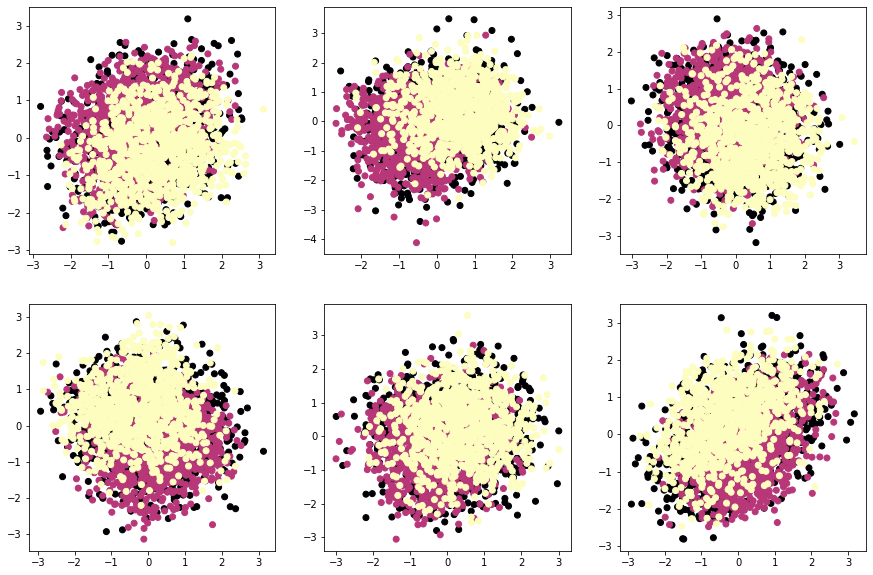

In [5]:
fig, axs = plt.subplots(2, 3, figsize=(15,10) )

cmap = 'magma'

axs[0][0].scatter(normalized_data.transpose()[0], normalized_data.transpose()[1], c = labels, cmap = cmap)
axs[0][1].scatter(normalized_data.transpose()[2], normalized_data.transpose()[3], c = labels, cmap = cmap)
axs[0][2].scatter(normalized_data.transpose()[4], normalized_data.transpose()[5], c = labels, cmap = cmap)
axs[1][0].scatter(normalized_data.transpose()[6], normalized_data.transpose()[7], c = labels, cmap = cmap)
axs[1][1].scatter(normalized_data.transpose()[8], normalized_data.transpose()[9], c = labels, cmap = cmap)
axs[1][2].scatter(normalized_data.transpose()[10], normalized_data.transpose()[11], c = labels, cmap = cmap)


## START. hyperparameters 

In [6]:
train_dataset, validation_dataset = random_split(data, labels, (2500,500) )

In [7]:
n = 10  # number of models/datasets
datasets = [
    torch.utils.data.Subset(train_dataset,torch.randint(len(train_dataset),(len(train_dataset),))) for i in range(n)]

In [8]:
train_loaders = [torch.utils.data.DataLoader(d, 
                                           batch_size=100, 
                                           shuffle=True) for d in datasets]

In [9]:
loss_f = nn.CrossEntropyLoss()

In [10]:
models = [torch.nn.Sequential(
    nn.Linear(12,1028), nn.ReLU(),
    nn.BatchNorm1d(1028),
    nn.Linear(1028,1028), nn.ReLU(),
    nn.BatchNorm1d(1028),
    nn.Linear(1028,1028), nn.ReLU(),
    nn.BatchNorm1d(1028),
    nn.Linear(1028,3),
    nn.BatchNorm1d(3)
) for i in range(len(datasets))]


In [11]:
lr = 0.01
optims = [torch.optim.SGD(models[i].parameters(), lr=lr, momentum=0.9999) for i in range(len(datasets))]


In [12]:
%%time
for i in range(len(datasets)):
    for e in range(300):
        for d in train_loaders[i]:        
            optims[i].zero_grad()
            features, labels = d
            pred = models[i](features)
            loss = loss_f(pred, labels)
            loss.backward()
            optims[i].step()
    
    print("i = ", i, "lr = ", lr, "loss = ", loss.item())   

i =  0 lr =  0.01 loss =  0.0007288024644367397
i =  1 lr =  0.01 loss =  1.9295604943181388e-05
i =  2 lr =  0.01 loss =  0.00021397830278147012
i =  3 lr =  0.01 loss =  2.1396826923592016e-06
i =  4 lr =  0.01 loss =  0.02879425138235092
i =  5 lr =  0.01 loss =  0.005988209042698145
i =  6 lr =  0.01 loss =  0.0008877688669599593
i =  7 lr =  0.01 loss =  0.0008850361919030547
i =  8 lr =  0.01 loss =  0.00017453180043958127
i =  9 lr =  0.01 loss =  7.841180376999546e-06
CPU times: user 3h 15min 13s, sys: 56min 46s, total: 4h 12min
Wall time: 1h 24min 4s


### Checking the accuracy of the model

In [13]:
with torch.no_grad():
    for i in range(len(datasets)):
        pred = torch.softmax(models[i](datasets[i][:][0]),1)
        ac = torch.sum(torch.argmax(pred,1)==datasets[i][:][1]).to(dtype=torch.float32)/len(datasets[i])
        print(ac)  

tensor(1.)
tensor(1.)
tensor(1.)
tensor(0.9992)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(0.9996)


In [14]:
with torch.no_grad():
    for i in range(len(datasets)):
        pred = torch.softmax(models[i](validation_dataset[:][0]),1)
        ac = torch.sum(torch.argmax(pred,1)==validation_dataset[:][1]).to(dtype=torch.float32)/len(validation_dataset)
        print(ac)    

tensor(0.6460)
tensor(0.6540)
tensor(0.6620)
tensor(0.6700)
tensor(0.6560)
tensor(0.6600)
tensor(0.6300)
tensor(0.6600)
tensor(0.6260)
tensor(0.6340)


## Save models to separate files

In [45]:
for i in range(len(datasets) ):
    name = "model_" + str(i) + ".pt" 
    torch.save( models[i], name)


In [15]:
def predict_class (model, inp):
    pred = torch.softmax(model(inp),dim=1)
    return torch.argmax(pred,dim=1)

In [17]:
preds = [predict_class(models[i], validation_dataset[:][0]) for i in range(len(datasets))]

In [18]:
def vote(predictions):
    npred=torch.stack(predictions, dim=1).numpy()
    v  = np.apply_along_axis(lambda r: np.bincount(r).argmax(), 1, npred)
    return torch.from_numpy(v)  

In [19]:
gold = vote(preds)
torch.sum(gold==validation_dataset[:][1]).item()/len(gold)

0.688